In [1]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Display Function Definition and Usage

In [2]:
def display_grid_and_path(inst: AgcspInstance, evaluator: AgcspEvaluator, path: List[Node]):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = len(inst.field_nodes)
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    path_arr = np.array(path)
    plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
             label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
             markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
# Create a circular grid with five small square obstacles scattered on the circle
center_r, center_c = 100, 100
outer_radius = 80
obstacle_half_size = 5  # Half-size of each small square obstacle

r_grid, c_grid = np.mgrid[0:200, 0:200]
dist_from_center = np.sqrt((r_grid - center_r)**2 + (c_grid - center_c)**2)
grid_nodes = np.argwhere(dist_from_center <= outer_radius)

# Create five small square obstacles at different positions on the circle
obstacle_positions = [
    (100, 140),  # Right
    (130, 115),  # Bottom-right
    (115, 70),   # Top-right
    (70, 85),    # Top-left
    (85, 130)    # Bottom-left
]

obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    obstacle = np.argwhere(
        (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
        (np.abs(c_grid - obs_c) <= obstacle_half_size)
    )
    obstacle_list.append(obstacle)

obstacle_nodes = np.vstack(obstacle_list)

circular_inst = AgcspInstance(grid_nodes, obstacle_nodes, 15, 90)
circular_evaluator = AgcspEvaluator(circular_inst)

Coverage: 5492/19448 nodes (28.2%)
Obstacles: 0/633 covered


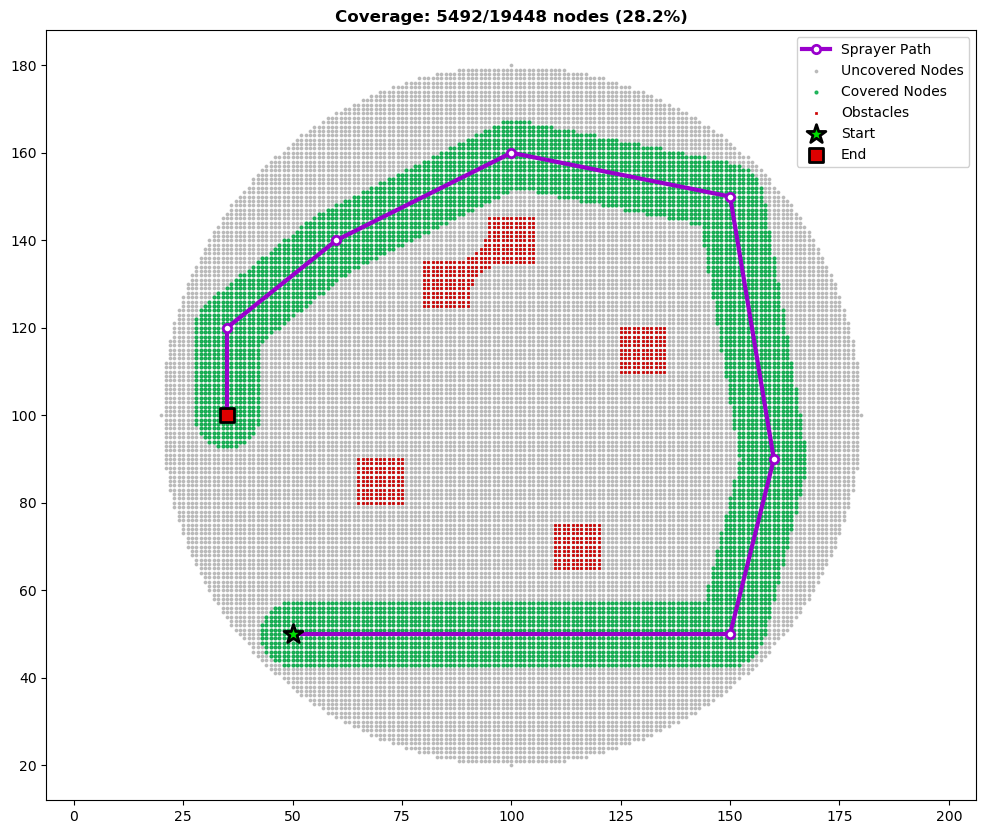

In [4]:
path=[(50, 50), (150, 50), (160, 90), (150, 150), (100, 160), (60, 140), (35, 120), (35, 100)]
display_grid_and_path(circular_inst, circular_evaluator, path)

# Evaluator and Cache testing

In [5]:
sol = AgcspSolution(path)
display(circular_evaluator.coverage_proportion(sol))
display(sol.cache['hits_obstacle'])
circular_evaluator.manouver_complexity_penalty(sol)

0.28239407651172355

False

2.0938904055817336

In [6]:
circular_evaluator.objfun(sol)

14762.124297405908

# Testing neighborhood step evaluations

### a) Node Removal Step

In [7]:
print("--- Teste do Movimento de Removal ---")

initial_sol_removal = AgcspSolution(path)
initial_cost_removal = circular_evaluator.objfun(initial_sol_removal)
print(f"Custo Inicial: {initial_cost_removal:.4f}")

node_idx_to_remove = 6
print(f"Ação: Remover o nó na posição {node_idx_to_remove}")

calculated_delta_removal = circular_evaluator.evaluate_removal_delta(initial_sol_removal, node_idx_to_remove)
print(f"Delta Calculado pelo método: {calculated_delta_removal:.4f}")

new_path_removal = np.delete(np.array(initial_sol_removal.path), node_idx_to_remove, axis=0)
new_sol_removal = AgcspSolution(new_path_removal)
new_cost_removal = circular_evaluator.objfun(new_sol_removal)
expected_delta_removal = new_cost_removal - initial_cost_removal

print(f"Custo da Nova Solução (recalculado): {new_cost_removal:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_removal:.4f}")

if np.isclose(calculated_delta_removal, expected_delta_removal):
    print("\nO método 'evaluate_removal_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")

--- Teste do Movimento de Removal ---
Custo Inicial: 14762.1243
Ação: Remover o nó na posição 6
Delta Calculado pelo método: 60.9866
Custo da Nova Solução (recalculado): 14823.1109
Delta Esperado (new_cost - old_cost): 60.9866

O método 'evaluate_removal_delta' está correto.


In [8]:
removal_delta_components = circular_evaluator.evaluate_removal_delta(initial_sol_removal, node_idx_to_remove, return_components=True)
print(removal_delta_components)

(66.08309337721069, -4.8457155268812215, -0.25078437202012516)


Coverage: 5492/19448 nodes (28.2%)
Obstacles: 0/633 covered


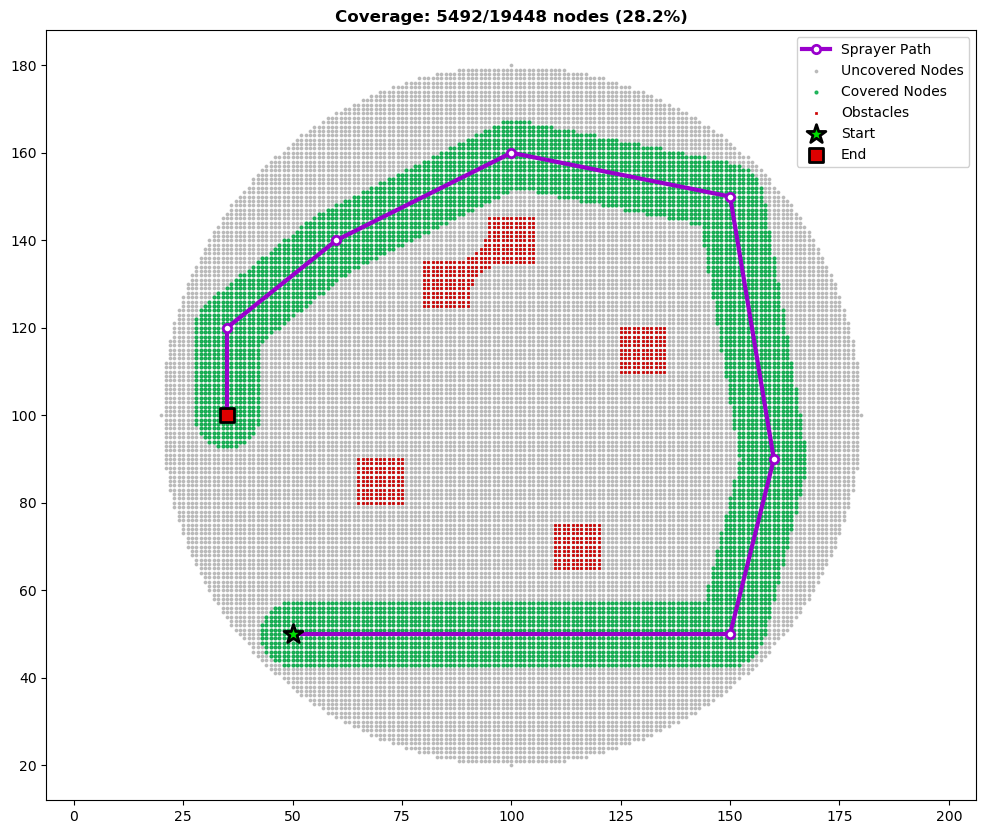

In [9]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 5428/19448 nodes (27.9%)
Obstacles: 0/633 covered


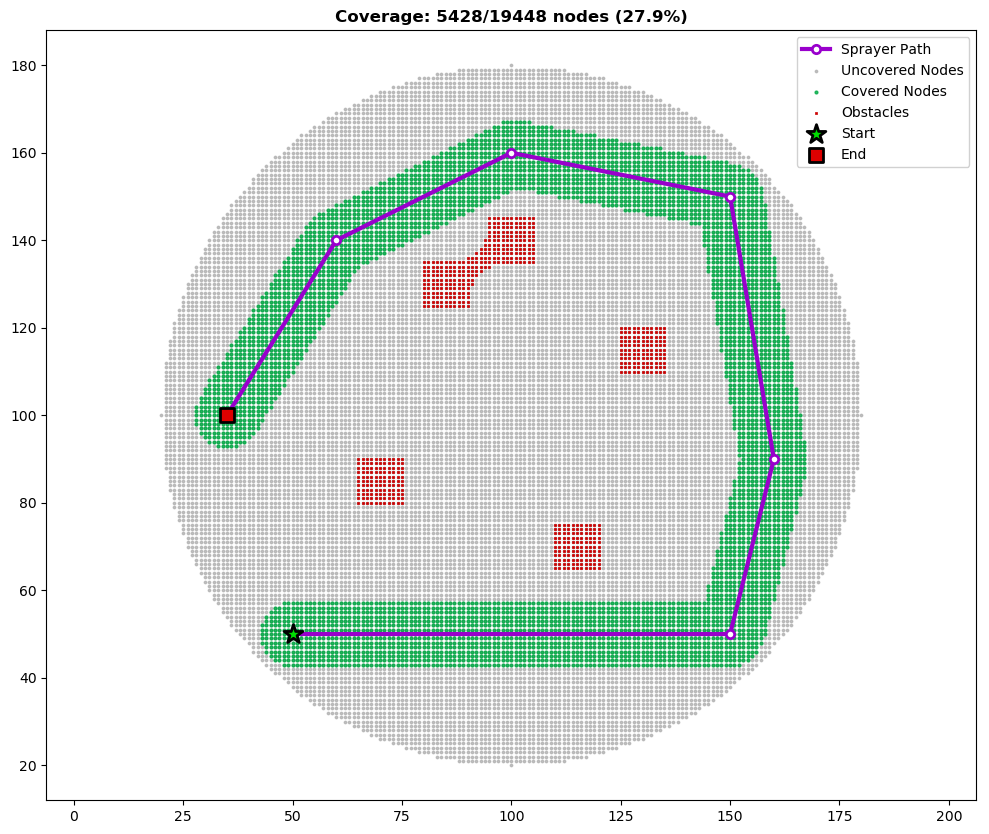

In [10]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_removal)

### b) Insertion Method

In [11]:
print("\n--- Teste do Movimento de Insertion ---")

initial_sol_insertion = AgcspSolution(path)
initial_cost_insertion = circular_evaluator.objfun(initial_sol_insertion)
print(f"Custo Inicial: {initial_cost_insertion:.4f}")

node_to_insert = (160, 60)  # New node to insert
insert_position = 2  # Position to insert the new node
print(f"Ação: Inserir o nó {node_to_insert} na posição {insert_position}")

calculated_delta_insertion = circular_evaluator.evaluate_insertion_delta(initial_sol_insertion, node_to_insert, insert_position)
print(f"Delta Calculado pelo método: {calculated_delta_insertion:.4f}")

new_path_insertion = np.insert(np.array(initial_sol_insertion.path), insert_position, node_to_insert, axis=0)
new_sol_insertion = AgcspSolution(new_path_insertion)
new_cost_insertion = circular_evaluator.objfun(new_sol_insertion)
expected_delta_insertion = new_cost_insertion - initial_cost_insertion

print(f"Custo da Nova Solução (recalculado): {new_cost_insertion:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_insertion:.4f}")

if np.isclose(calculated_delta_insertion, expected_delta_insertion):
    print("\nO método 'evaluate_insertion_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Insertion ---
Custo Inicial: 14762.1243
Ação: Inserir o nó (160, 60) na posição 2
Delta Calculado pelo método: -24.1762
Custo da Nova Solução (recalculado): 14737.9481
Delta Esperado (new_cost - old_cost): -24.1762

O método 'evaluate_insertion_delta' está correto.


In [12]:
insertion_delta_components = circular_evaluator.evaluate_insertion_delta(initial_sol_insertion, node_to_insert, insert_position, return_components=True)
print(insertion_delta_components)

(-26.846256684492086, 2.9110793675543434, -0.24100180491567058)


Coverage: 5492/19448 nodes (28.2%)
Obstacles: 0/633 covered


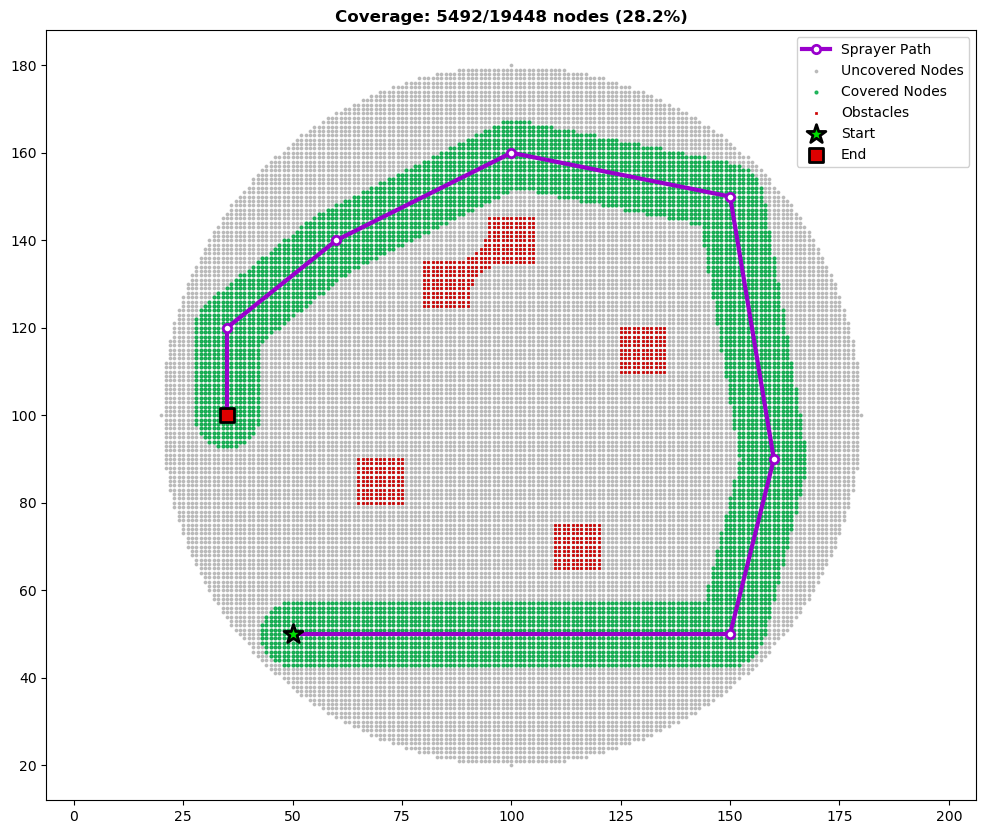

In [13]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 5518/19448 nodes (28.4%)
Obstacles: 0/633 covered


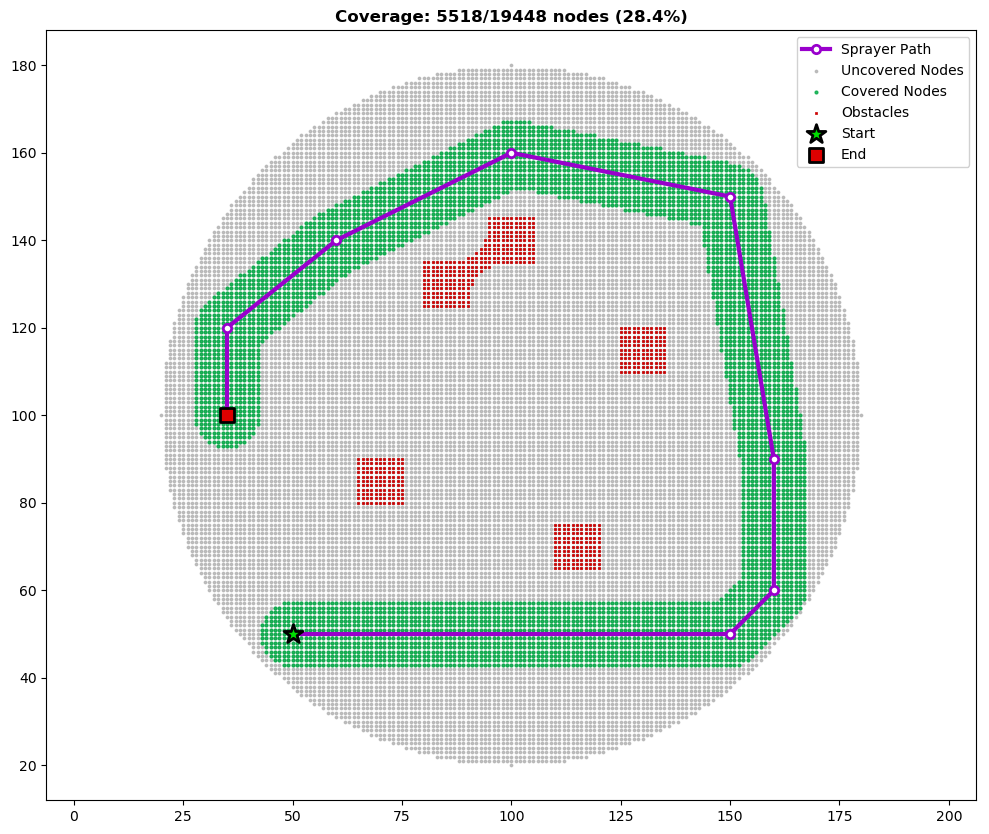

In [14]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_insertion)

### c) Node swap step

In [15]:
print("\n--- Teste do Movimento de Swap ---")

initial_sol_swap = AgcspSolution(path)
initial_cost_swap = circular_evaluator.objfun(initial_sol_swap)
print(f"Custo Inicial: {initial_cost_swap:.4f}")

idx1, idx2 = 1, 3
print(f"Ação: Trocar os nós nas posições {idx1} e {idx2}")

calculated_delta_swap = circular_evaluator.evaluate_swap_delta(initial_sol_swap, idx1, idx2)
print(f"Delta Calculado pelo método: {calculated_delta_swap:.4f}")

new_path_swap = np.array(initial_sol_swap.path).copy()
new_path_swap[idx1], new_path_swap[idx2] = new_path_swap[idx2].copy(), new_path_swap[idx1].copy()
new_sol_swap = AgcspSolution(new_path_swap)
new_cost_swap = circular_evaluator.objfun(new_sol_swap)
expected_delta_swap = new_cost_swap - initial_cost_swap

print(f"Custo da Nova Solução (recalculado): {new_cost_swap:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_swap:.4f}")

if np.isclose(calculated_delta_swap, expected_delta_swap):
    print("\nO método 'evaluate_swap_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Swap ---
Custo Inicial: 14762.1243
Ação: Trocar os nós nas posições 1 e 3
Delta Calculado pelo método: inf
Custo da Nova Solução (recalculado): 13571.0324
Delta Esperado (new_cost - old_cost): -1191.0919

O delta calculado é diferente do esperado.


Coverage: 5492/19448 nodes (28.2%)
Obstacles: 0/633 covered


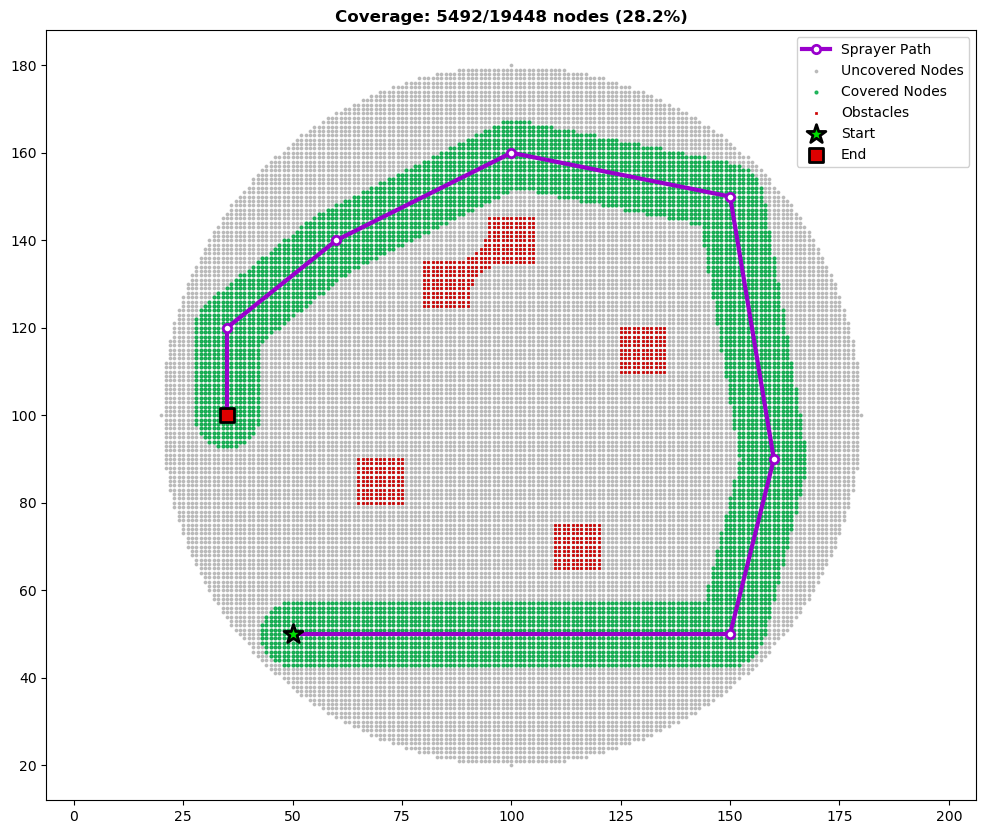

In [16]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 6627/19448 nodes (34.1%)
Obstacles: 0/633 covered


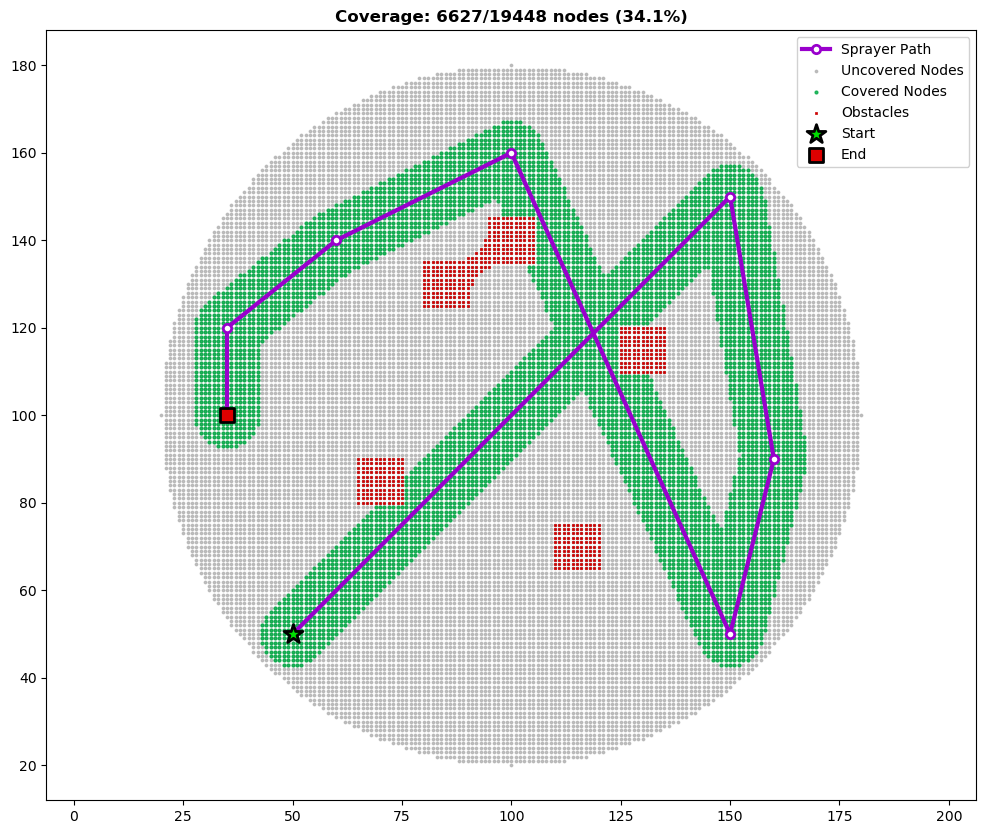

In [17]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_swap)

### d) Node move step

In [18]:
print("\n--- Teste do Movimento de Move ---")

initial_sol_move = AgcspSolution(path)
initial_cost_move = circular_evaluator.objfun(initial_sol_move)
print(f"Custo Inicial: {initial_cost_move:.4f}")

node_idx_to_move = 0
min_distance = 10
direction = 'up'
print(f"Ação: Mover o nó na posição {node_idx_to_move} para a direção '{direction}' com distância mínima {min_distance}")

calculated_delta_move = circular_evaluator.evaluate_move_delta(initial_sol_move, node_idx_to_move, min_distance, direction)

if calculated_delta_move is None:
    print("Nenhum nó válido encontrado na direção especificada.")
elif calculated_delta_move == float('inf'):
    print("O movimento resultaria em uma solução inválida (colisão com obstáculo ou ângulo de virada inválido).")
else:
    print(f"Delta Calculado pelo método: {calculated_delta_move:.4f}")
    
    # Find the new node to verify
    new_node = circular_evaluator._find_node_in_direction(
        np.array(initial_sol_move.path[node_idx_to_move]), min_distance, direction
    )
    print(f"Nó original: {initial_sol_move.path[node_idx_to_move]}, Novo nó: {tuple(new_node)}")
    
    # Create the new path manually
    new_path_move = np.array(initial_sol_move.path).copy()
    new_path_move[node_idx_to_move] = new_node
    new_sol_move = AgcspSolution(new_path_move)
    new_cost_move = circular_evaluator.objfun(new_sol_move)
    expected_delta_move = new_cost_move - initial_cost_move
    
    print(f"Custo da Nova Solução (recalculado): {new_cost_move:.4f}")
    print(f"Delta Esperado (new_cost - old_cost): {expected_delta_move:.4f}")
    
    if np.isclose(calculated_delta_move, expected_delta_move):
        print("\nO método 'evaluate_move_delta' está correto.")
    else:
        print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Move ---
Custo Inicial: 14762.1243
Ação: Mover o nó na posição 0 para a direção 'up' com distância mínima 10
Delta Calculado pelo método: -38.6403
Nó original: [50. 50.], Novo nó: (50, 60)
Custo da Nova Solução (recalculado): 14723.4840
Delta Esperado (new_cost - old_cost): -38.6403

O método 'evaluate_move_delta' está correto.


In [19]:
move_delta_components = circular_evaluator.evaluate_move_delta(initial_sol_move, node_idx_to_move, min_distance, direction, return_components=True)
print(move_delta_components)

(-39.23683669271972, 0.49875621120889946, 0.09773644491914724)


Coverage: 5492/19448 nodes (28.2%)
Obstacles: 0/633 covered


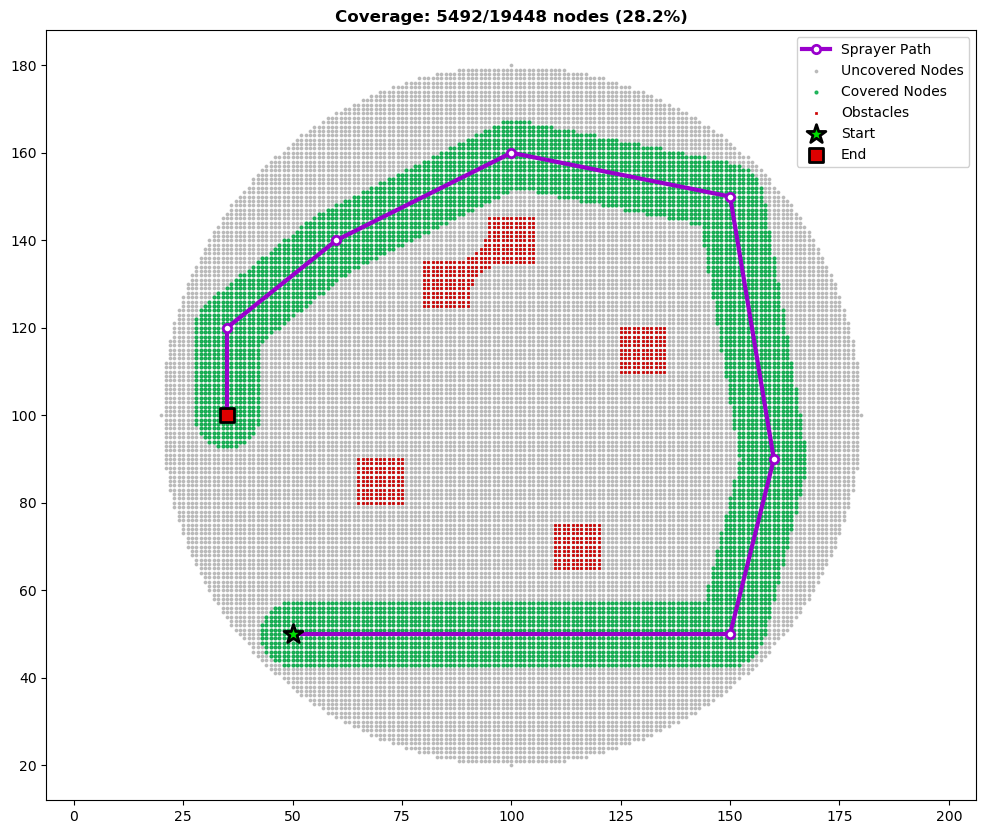

In [20]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 5530/19448 nodes (28.4%)
Obstacles: 0/633 covered


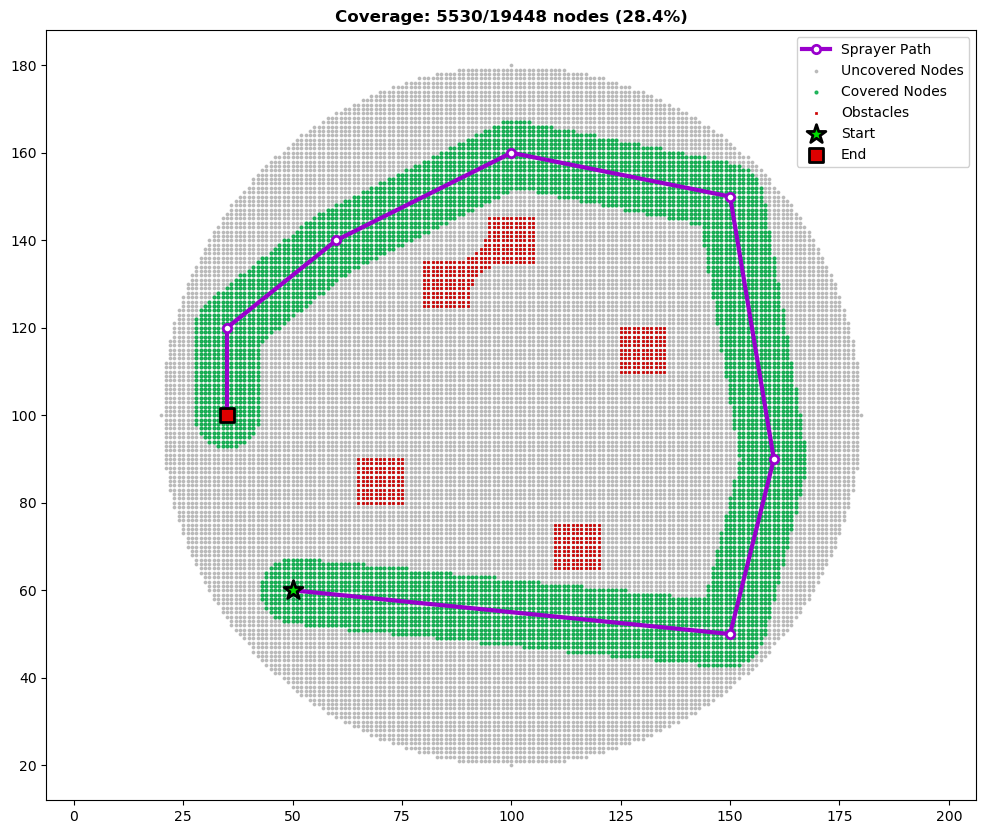

In [21]:
if calculated_delta_move is not None and calculated_delta_move != float('inf'):
    display_grid_and_path(circular_inst, circular_evaluator, new_path_move)

# Testing Construction Heuristic

In [22]:
from agricultural_csp.solver.agcsp_ts import *

In [23]:
ts = AgcspTS(circular_inst)

In [24]:
circular_inst.field_nodes

array([[113,  26],
       [ 44, 155],
       [118, 104],
       ...,
       [138,  83],
       [102, 160],
       [ 41, 150]])

In [25]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.BOUSTROPHEDON_SEGMENTED)

  Iniciando em (68, 27)


Coverage: 13802/19448 nodes (71.0%)
Obstacles: 0/633 covered


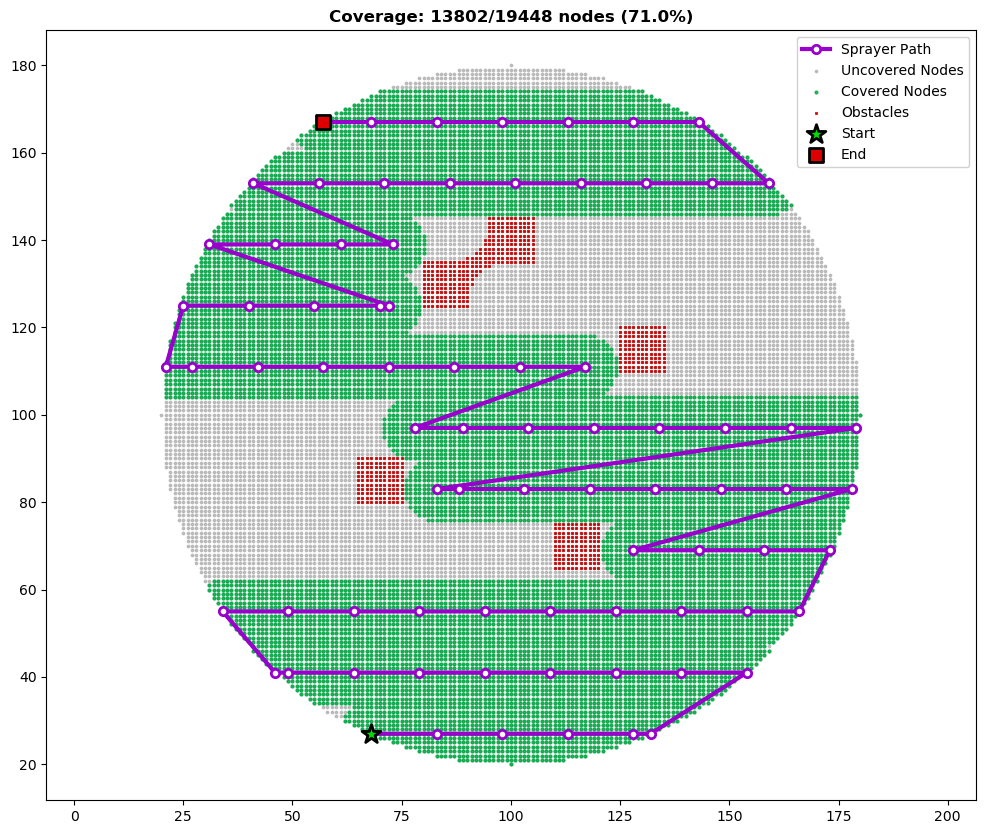

In [26]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)

In [27]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.RANDOM)

Current coverage: 0.0000, path length: 1, uncovered: 20081
Current coverage: 0.0679, path length: 2, uncovered: 18760
Current coverage: 0.1315, path length: 3, uncovered: 17524
Current coverage: 0.1912, path length: 4, uncovered: 16363
Current coverage: 0.2108, path length: 5, uncovered: 15982
Current coverage: 0.3040, path length: 6, uncovered: 14168
Current coverage: 0.3174, path length: 7, uncovered: 13908
Current coverage: 0.3308, path length: 8, uncovered: 13647
Current coverage: 0.3606, path length: 9, uncovered: 13068
Current coverage: 0.3879, path length: 10, uncovered: 12538
Current coverage: 0.4122, path length: 11, uncovered: 12065
Current coverage: 0.4328, path length: 12, uncovered: 11663
Current coverage: 0.4684, path length: 13, uncovered: 10972
Current coverage: 0.4761, path length: 14, uncovered: 10822
Current coverage: 0.4900, path length: 15, uncovered: 10552
Current coverage: 0.5219, path length: 16, uncovered: 9932
Current coverage: 0.5646, path length: 17, uncover

Coverage: 16179/19448 nodes (83.2%)
Obstacles: 0/633 covered


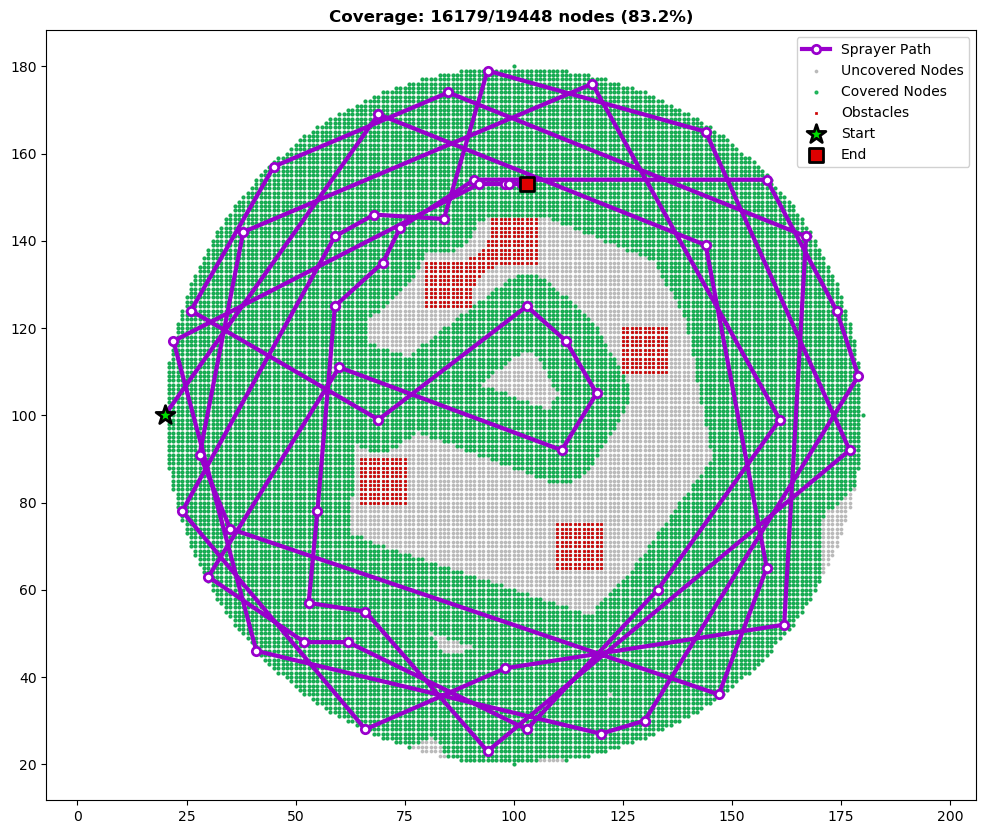

In [28]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)

In [29]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.FSM_COVERAGE_PLANNER)

After axis scanning 'C', current coverage: 96.50%
After axis scanning 'R', current coverage: 99.60%
Path simplification reduced points from 3109 to 277.


Coverage: 19370/19448 nodes (99.6%)
Obstacles: 0/633 covered


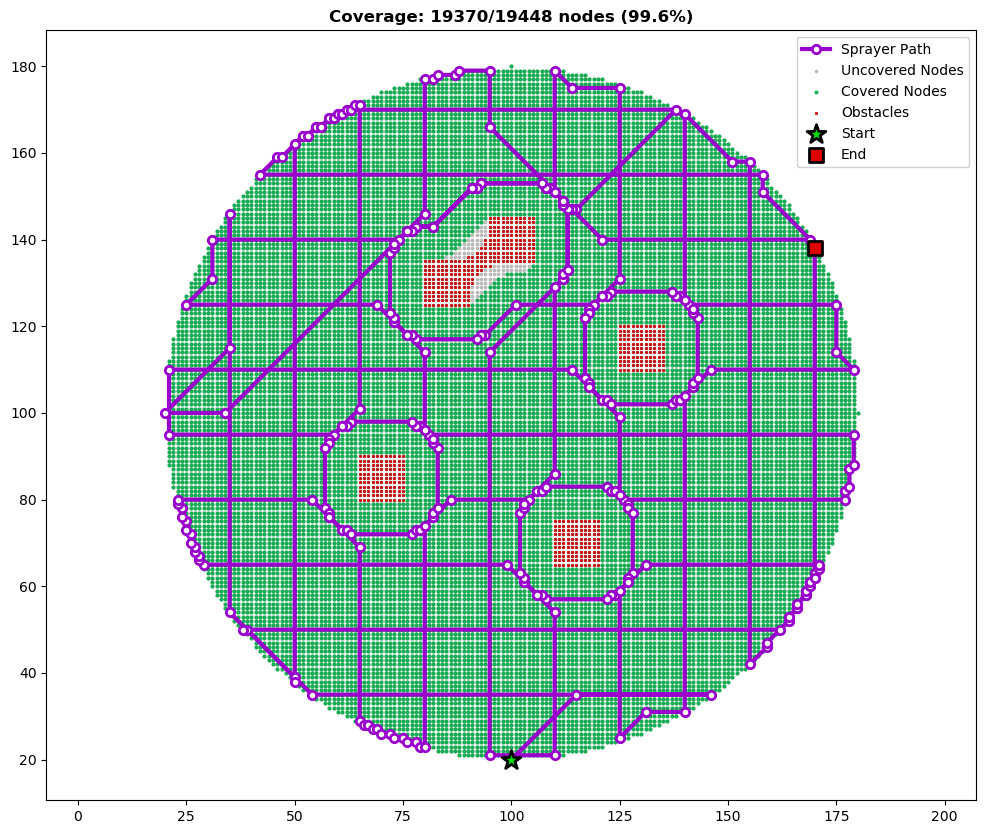

In [30]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)